In [1]:
import pandas as pd

full_dataset_confounders_2014 = pd.read_csv('processed_data/full_dataset_confounders_2014.csv')
full_dataset_confounders_2015 = pd.read_csv('processed_data/full_dataset_confounders_2015.csv')
full_dataset_confounders_2016 = pd.read_csv('processed_data/full_dataset_confounders_2016.csv')


In [2]:
full_dataset_confounders_2014.set_index('osward', inplace=True)
full_dataset_confounders_2015.set_index('osward', inplace=True)
full_dataset_confounders_2016.set_index('osward', inplace=True)

In [3]:
full_dataset_confounders_2014_subset = full_dataset_confounders_2014.drop(['arts_count', 'cinema_count', 'gallery_count',
'comm_center_count', 'dance_count', 'lgbt_count', 'library_count', 'museum_count', 'music_count', 'outdoor_count',
'pub_count', 'skate_count', 'theatre_count', 'TOTAL_QUANTITY'], axis=1)

In [4]:
full_dataset_confounders_2014_subset.total_count = full_dataset_confounders_2014_subset.total_count.astype('int')

In [5]:
def get_treatment_level(input):
    if input < 2:
        return 0
    elif input < 10:
        return 1
    elif input < 50:
        return 2
    else:
        return 3

In [6]:
treatment_levels = [get_treatment_level(x) for x in list(full_dataset_confounders_2014_subset.total_count)]

In [7]:
full_dataset_confounders_2014_subset.total_count = treatment_levels

In [8]:
from sklearn.linear_model import LogisticRegression as lr

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics

In [9]:
import math
import numpy as np
import pandas as pd
# import scipy.stats as stats

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set(rc={'figure.figsize':(16,10)}, font_scale=1.3)

In [10]:
T = full_dataset_confounders_2014_subset.total_count
X = full_dataset_confounders_2014_subset.loc[:,full_dataset_confounders_2014_subset.columns !='total_count']

In [11]:
y = full_dataset_confounders_2014[['TOTAL_QUANTITY']]

In [12]:
T

osward
E05000026    2
E05000027    0
E05000028    0
E05000029    1
E05000030    1
            ..
E05011485    2
E05011486    1
E05011487    1
E05011488    1
E05011489    1
Name: total_count, Length: 573, dtype: int64

In [13]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', lr())
])

pipe.fit(X, T)

Pipeline(steps=[('scaler', StandardScaler()),
                ('logistic_classifier', LogisticRegression())])

In [14]:
predictions = pipe.predict_proba(X)
predictions_binary = pipe.predict(X)

In [15]:
print('Accuracy: {:.4f}\n'.format(metrics.accuracy_score(T, predictions_binary)))
print('Confusion matrix:\n{}\n'.format(metrics.confusion_matrix(T, predictions_binary)))
print('F1 score is:', metrics.f1_score(T, predictions_binary, average=None))

Accuracy: 0.6981

Confusion matrix:
[[  1  25   1   0]
 [  0 307  27   0]
 [  0 112  85   1]
 [  0   3   4   7]]

F1 score is: [0.07142857 0.78617157 0.53968254 0.63636364]


In [16]:
def logit(p):
    logit_value = math.log(p / (1-p))
    return logit_value


In [17]:
predictions_logit = np.array([logit(xi) for xi in predictions[:,1]])


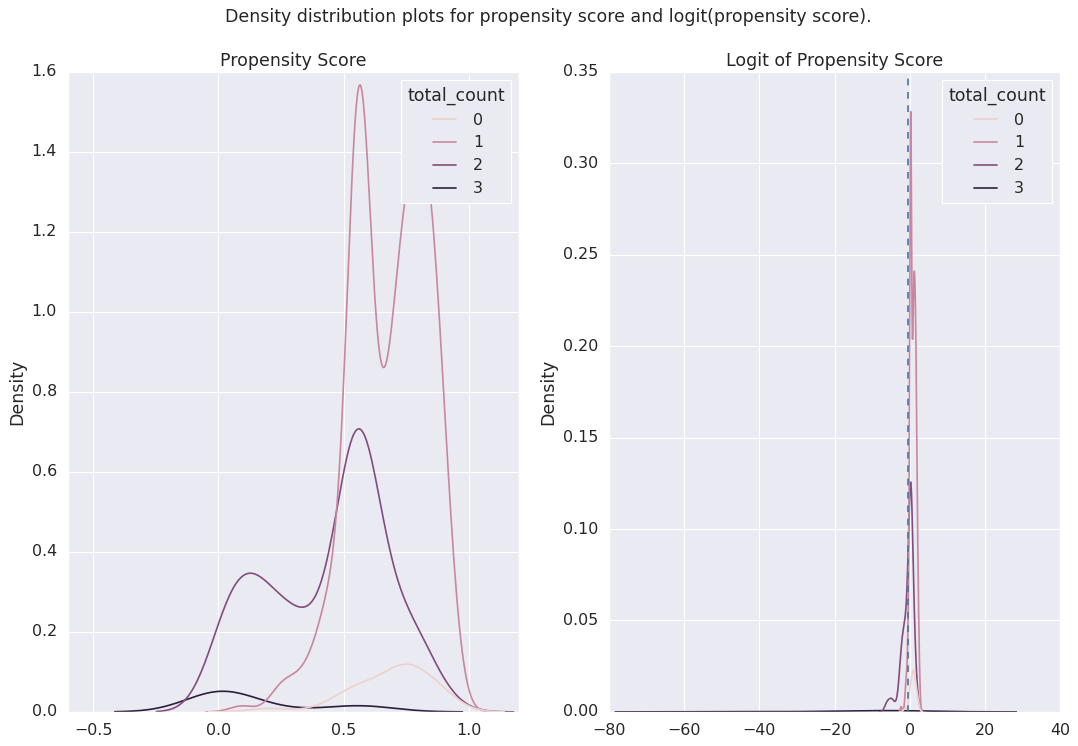

In [18]:
# Density distribution of propensity score (logic) broken down by treatment status
fig, ax = plt.subplots(1,2)
fig.suptitle('Density distribution plots for propensity score and logit(propensity score).')
sns.kdeplot(x = predictions[:,1], hue = T , ax = ax[0])
ax[0].set_title('Propensity Score')
sns.kdeplot(x = predictions_logit, hue = T , ax = ax[1])
ax[1].axvline(-0.4, ls='--')
ax[1].set_title('Logit of Propensity Score')
plt.show()

In [19]:
# Currently this does not affect the results as all observations fall within this range.
common_support = (predictions_logit > -10) & (predictions_logit < 10)

In [20]:
full_dataset_confounders_2014.loc[:,'propensity_score'] = predictions[:,1]
full_dataset_confounders_2014.loc[:,'propensity_score_logit'] = predictions_logit
full_dataset_confounders_2014.loc[:,'outcome'] = y.TOTAL_QUANTITY

X.loc[:,'propensity_score'] = predictions[:,1]
X.loc[:,'propensity_score_logit'] = predictions_logit
X.loc[:,'outcome'] = y.TOTAL_QUANTITY
X.loc[:,'treatment'] = full_dataset_confounders_2014.total_count

Matching implementation

In [21]:
caliper = np.std(full_dataset_confounders_2014.propensity_score) * 0.25

print('\nCaliper (radius) is: {:.4f}\n'.format(caliper))

df_data = X

knn = NearestNeighbors(n_neighbors=10 , p = 2, radius=caliper)
knn.fit(df_data[['propensity_score_logit']].to_numpy())


Caliper (radius) is: 0.0578



NearestNeighbors(n_neighbors=10, radius=0.057824180818875415)

In [22]:
# Common support distances and indexes
distances , indexes = knn.kneighbors(
    df_data[['propensity_score_logit']].to_numpy(), \
    n_neighbors=10)

In [23]:
print('For item 0, the 4 closest distances are (first item is self):')
for ds in distances[0,0:4]:
    print('Element distance: {:4f}'.format(ds))
print('...')

For item 0, the 4 closest distances are (first item is self):
Element distance: 0.000000
Element distance: 0.006134
Element distance: 0.006598
Element distance: 0.034455
...


In [24]:
print('For item 0, the 4 closest indexes are (first item is self):')
for idx in indexes[0,0:4]:
    print('Element index: {}'.format(idx))
print('...')

For item 0, the 4 closest indexes are (first item is self):
Element index: 0
Element index: 414
Element index: 341
Element index: 161
...


In [25]:
import networkx as nx

In [26]:
G = nx.Graph()

In [27]:
G.add_nodes_from(df_data.reset_index()['osward'].tolist())

In [28]:
G

In [29]:
df_data_no_index = df_data.reset_index()
epsilon = 0.0001
for index, row in df_data_no_index.iterrows():
    other_rows = df_data_no_index[df_data_no_index['treatment'] != row.treatment]
    for o_index, o_row in other_rows.reset_index().iterrows():
        modified_distance = (abs(row.propensity_score_logit - o_row.propensity_score_logit) + epsilon) / abs(row.treatment - o_row.treatment)
        if not G.has_edge(row.osward, o_row.osward):
            G.add_edge(row.osward, o_row.osward, weight=modified_distance)


In [30]:
from networkx.algorithms.tree.branchings import maximum_branching



In [31]:
edmonds_applied = maximum_branching(G)

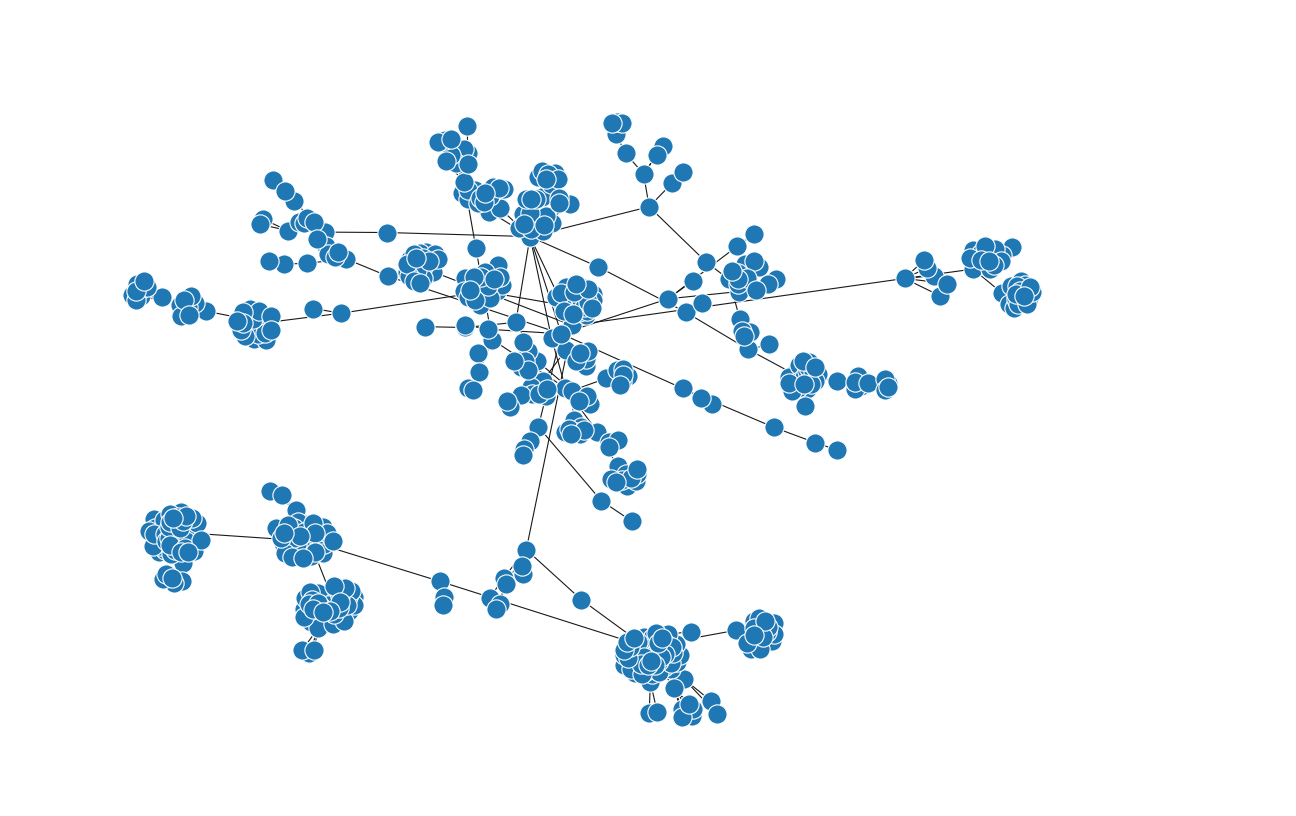

In [32]:
# pos = nx.random_layout(edmonds_applied)
nx.draw(edmonds_applied)

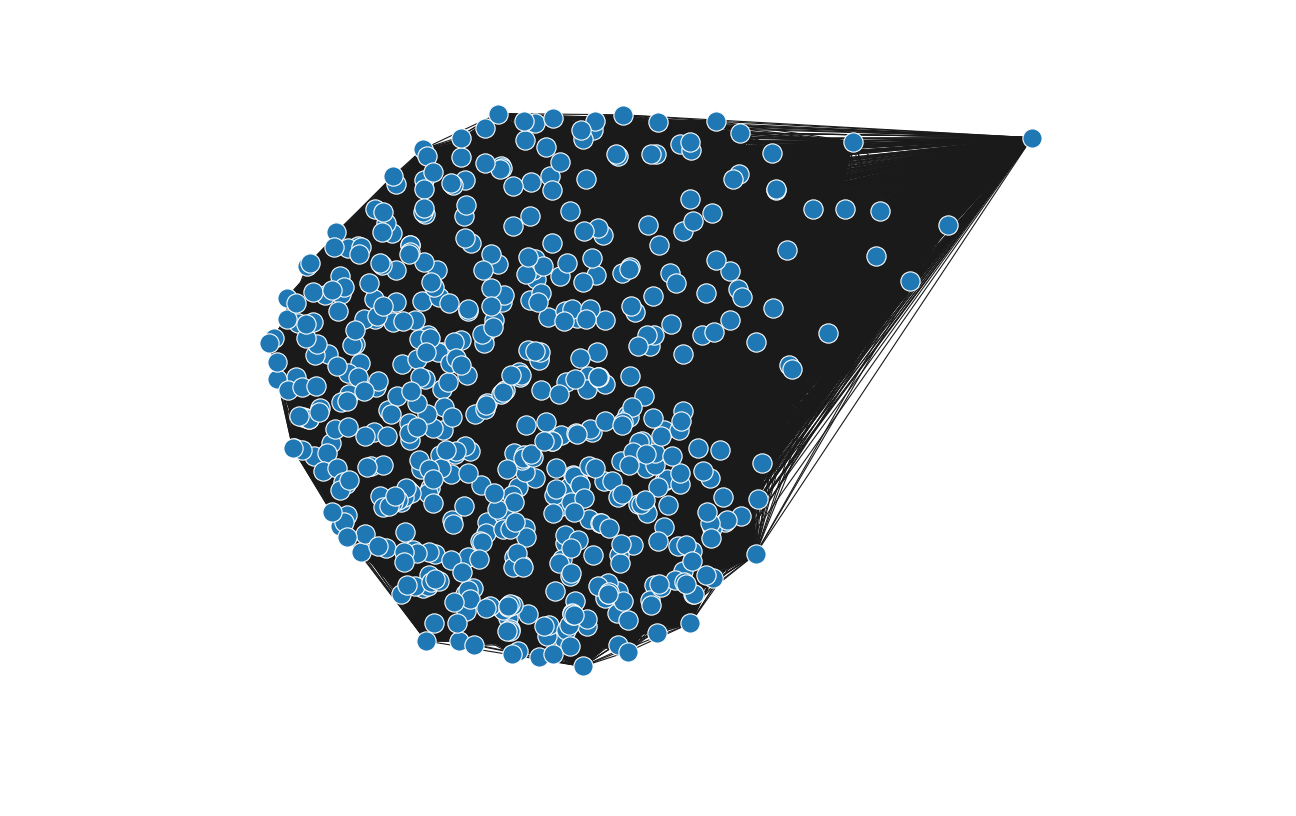

In [33]:
nx.draw(G)

Spearman correlation: 0.05106723267395223 p-value: 0.22225841545671005


/home/bvankooten/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1254: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


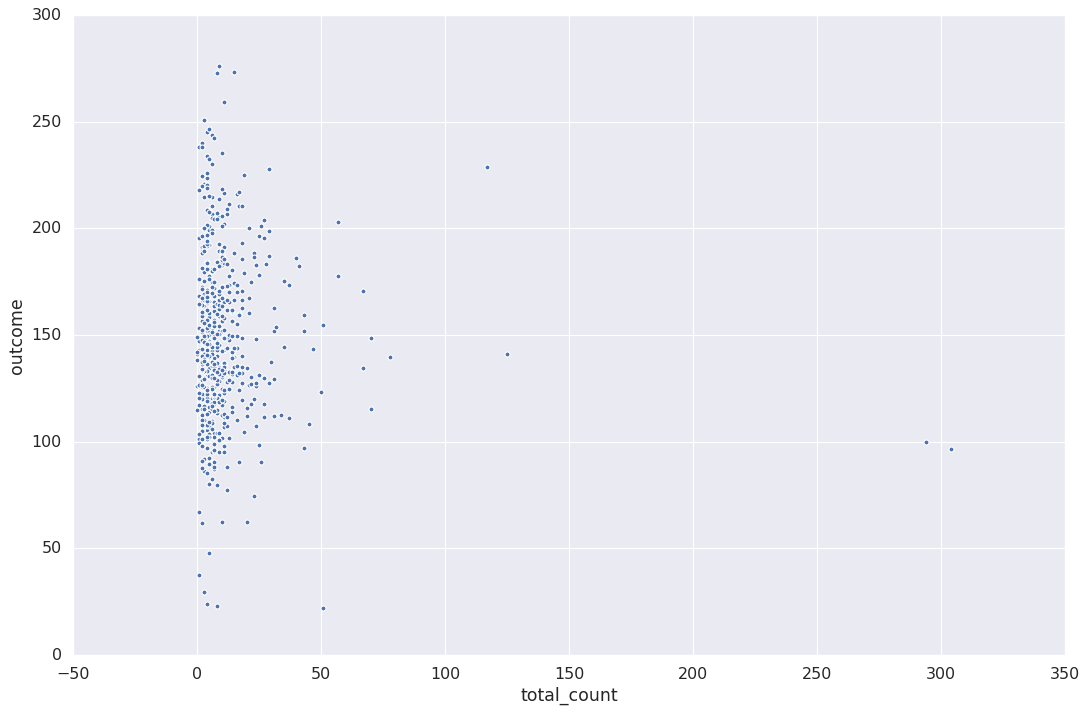

In [93]:
import scipy.stats as stats

correlation = full_dataset_confounders_2014[['total_count', 'outcome']]
correlation.plot.scatter(x='total_count', y='outcome')
spear_corr = stats.spearmanr(list(correlation['total_count']), list(correlation['outcome']))
print('Spearman correlation:', spear_corr.correlation, 'p-value:', spear_corr.pvalue)

In [70]:
distances = []
treatment_effect = []
for (u,v) in edmonds_applied.edges():
    distances.append(G[u][v]['weight'])
    effect = (df_data['outcome'][u] - df_data['outcome'][v])/(df_data['treatment'][u] - df_data['treatment'][v])
    treatment_effect.append(effect)

distribution_data = pd.DataFrame(list(zip(distances,treatment_effect)), columns = ['Distance', 'Effect'])

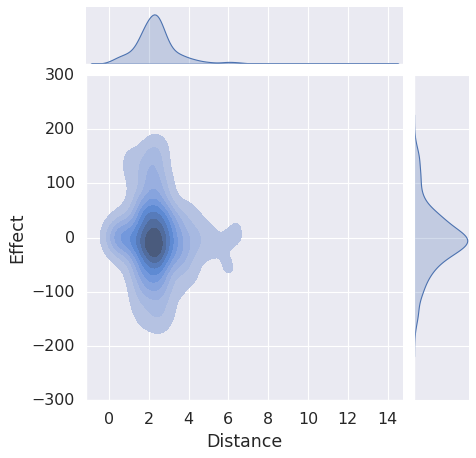

In [85]:
import seaborn as sns

sns.jointplot(distribution_data, x='Distance', y='Effect', kind='kde', fill=True)